#### **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**Change Folder path**

In [2]:
%cd /content/drive/MyDrive/hide_mdata_unet_roi


/content/drive/MyDrive/hide_mdata_unet_roi


### **Importing the Libraries**

In [3]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

### **Loading the Data**

Defining a function to load the data in sorted order

In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
filelist_trainx = sorted(glob.glob('/content/drive/MyDrive/hide_mdata_unet_roi/datasets/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/drive/MyDrive/hide_mdata_unet_roi/datasets/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

Splitting the dataset into training set and test set to verify our model performance without any bias.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 101)

Let's plot an image to see how the original images look.

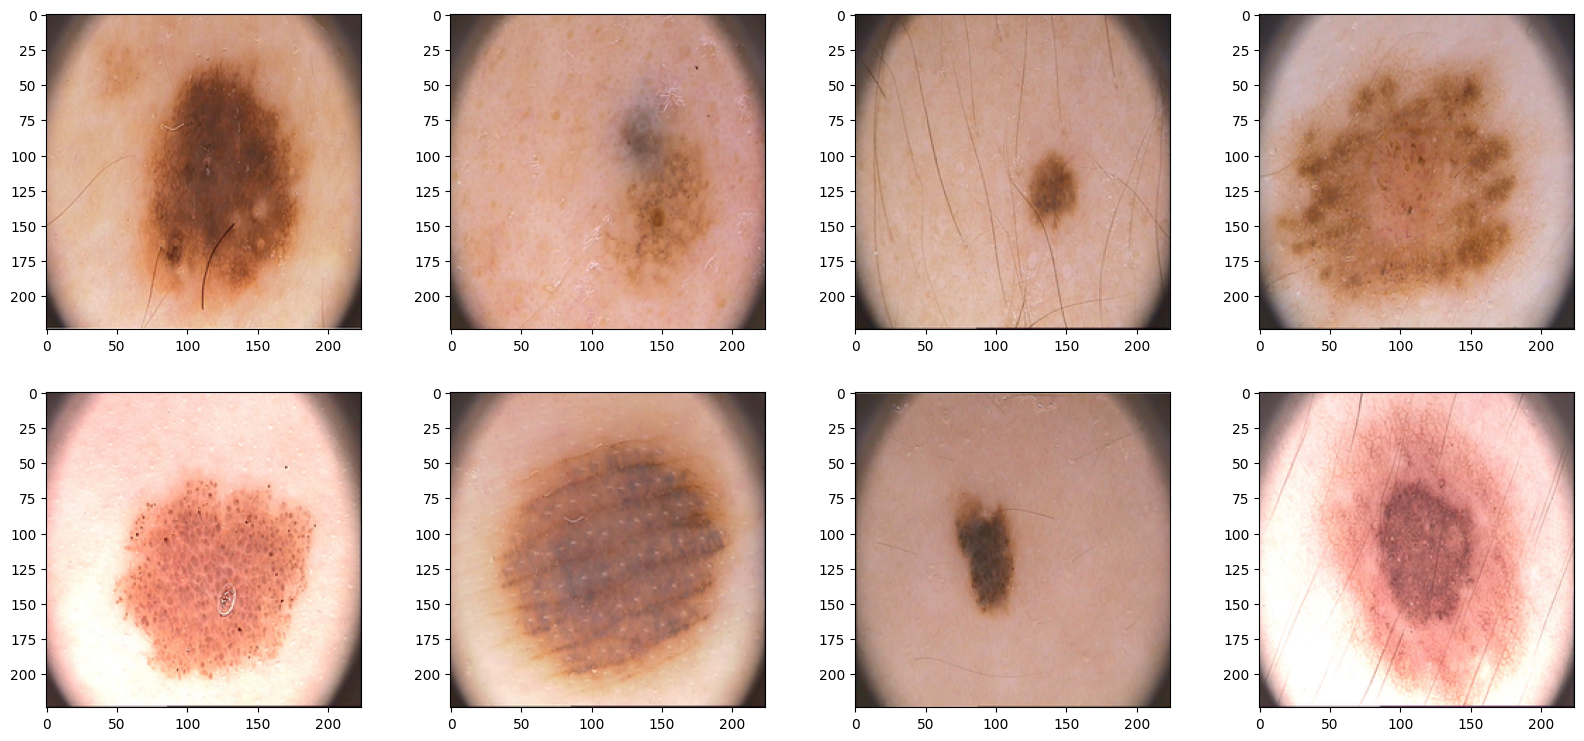

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

Now let's see their corresponding masks.

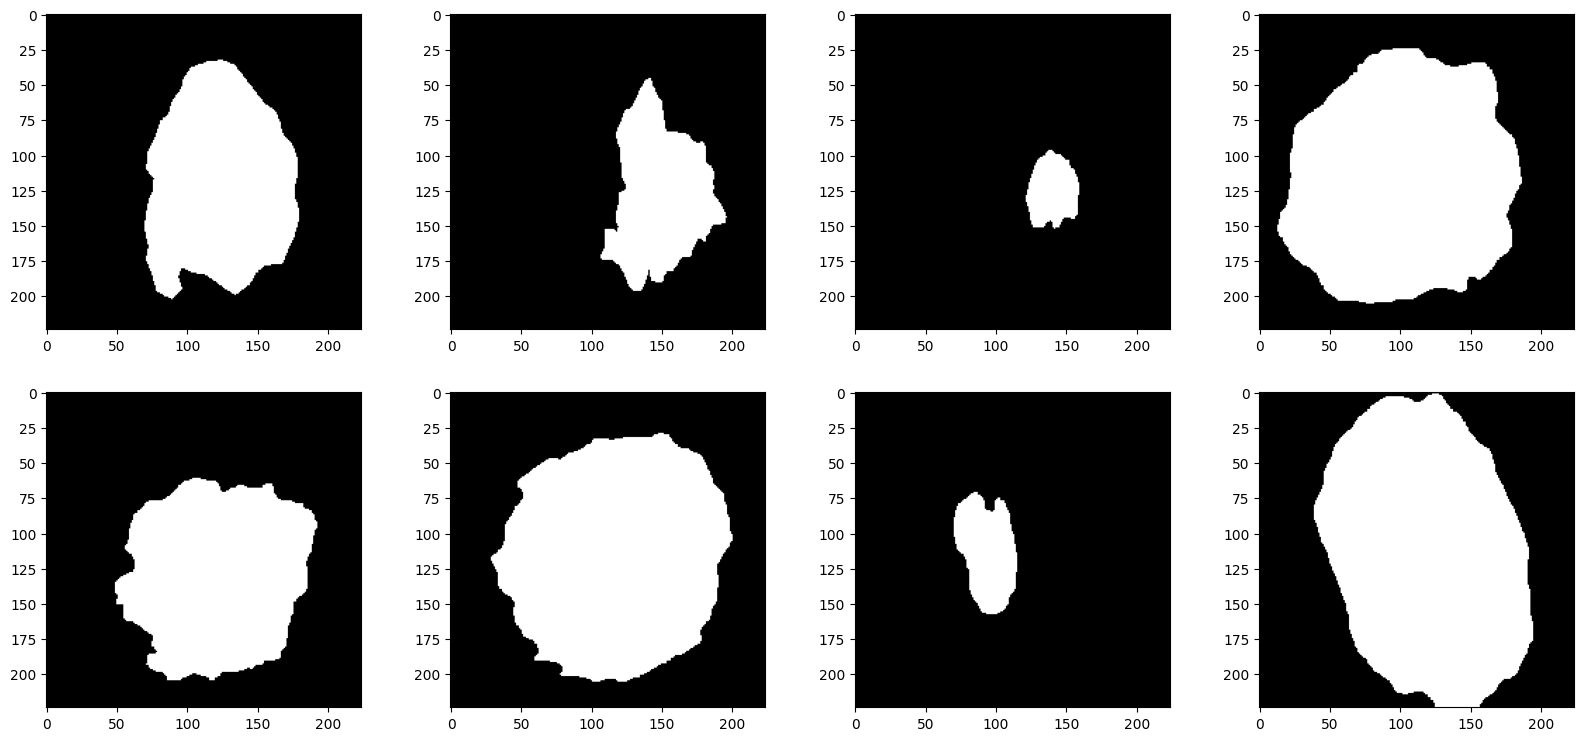

In [8]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

## Defining the Loss Function

#### Jaccard Distance  
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union:

![jd](https://www.geeksforgeeks.org/wp-content/ql-cache/quicklatex.com-44046533fcd54e98cb53619b3390e083_l3.svg)

In [9]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

## Defining Evaluation Metrics

#### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

In [10]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Dice coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [11]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Precision    
Precision is a good measure to determine, when the costs of False Positive is high.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [12]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Recall  
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [13]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Accuracy

In [14]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

### **Image Augmentation**
To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [15]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [16]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [17]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

Let us have a look at our transformations.

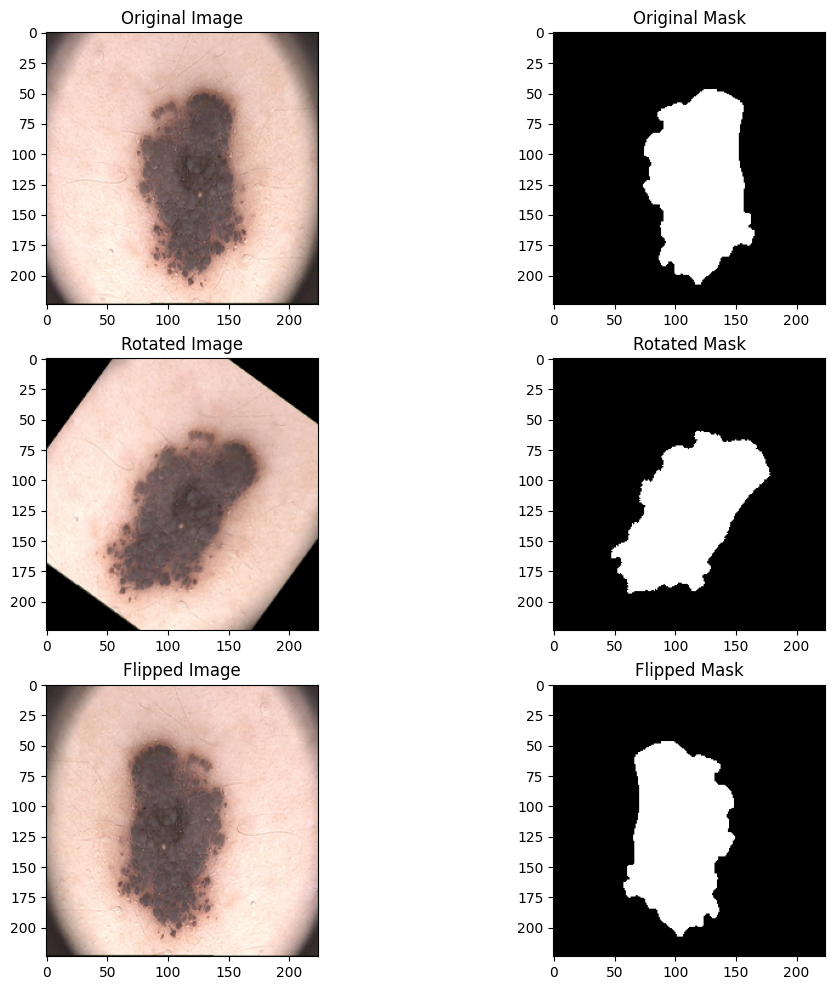

In [18]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [19]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#### Making a Validation Set  
We will split our full training set into train and validation set.
Validation dataset is used to validate the performance after each epoch.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [21]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 384
Length of the Test Set       : 40
Length of the Validation Set : 96


## The Model

Defining the model in a function which takes two arguments when called
* **epoch_num**: number of epochs to run  
* **savename**: the name of the model for saving after training

### Model Function

In [22]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.9 MB/s eta 0:00:00


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.activations as activations
import tensorflow.keras.metrics as metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons.optimizers as optimizers
import tensorflow_addons.losses as losses

def cbam_block(input_feature, ratio=8):
    channel_avg = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
    channel_max = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)

    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1] // ratio,
                                              activation='relu', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(channel_avg)
    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1],
                                              activation='sigmoid', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(channel_attention)

    channel_refined_feature = input_feature * channel_attention

    spatial_avg = tf.reduce_mean(channel_refined_feature, axis=-1, keepdims=True)
    spatial_max = tf.reduce_max(channel_refined_feature, axis=-1, keepdims=True)

    spatial_attention = tf.keras.layers.Dense(units=1,
                                              activation='relu', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(tf.concat([spatial_avg, spatial_max], axis=-1))
    spatial_attention = tf.keras.layers.Activation('sigmoid')(spatial_attention)

    refined_feature = channel_refined_feature * spatial_attention

    return refined_feature



def encoder_block(inputs, n_filters, kernel_size, strides, use_cbam=True):
    # Convolutional block
    encoder = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(inputs)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation(activations.gelu)(encoder)
    encoder = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', use_bias=False)(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder_output = layers.Activation(activations.gelu)(encoder)

    # CBAM module
    if use_cbam:
        encoder_output = cbam_block(encoder_output)

    return encoder_output




# Define the upscale blocks
def upscale_blocks(inputs):
    n_upscales = len(inputs)
    upscale_layers = []

    for i, inp in enumerate(inputs):
        p = n_upscales - i
        u = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2**p, padding='same')(inp)

        for i in range(2):
            u = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(u)
            u = layers.BatchNormalization()(u)
            u = layers.Activation(activations.gelu)(u)
            u = layers.Dropout(rate=0.4)(u)

        upscale_layers.append(u)
    return upscale_layers

# Define the decoder blocks
def decoder_block(layers_to_upscale, inputs):
    upscaled_layers = upscale_blocks(layers_to_upscale)

    decoder_blocks = []

    for i, inp in enumerate(inputs):
        d = layers.Conv2D(filters=64, kernel_size=3, strides=2**i, padding='same', use_bias=False)(inp)
        d = layers.BatchNormalization()(d)
        d = layers.Activation(activations.gelu)(d)
        d = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(d)
        d = layers.BatchNormalization()(d)
        d = layers.Activation(activations.gelu)(d)

        decoder_blocks.append(d)

    decoder = layers.concatenate(upscaled_layers + decoder_blocks)
    decoder = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', use_bias=False)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation(activations.gelu)(decoder)
    decoder = layers.Dropout(rate=0.4)(decoder)

    return decoder




def unet_3plus_deformable():
    input_img = Input((224, 224, 3))

    # Encoder blocks

    encoder1 = encoder_block(input_img, n_filters=32, kernel_size=3, strides=1)
    encoder2 = encoder_block(encoder1, n_filters=64, kernel_size=3, strides=2)
    encoder3 = encoder_block(encoder2, n_filters=128, kernel_size=3, strides=2)
    encoder4 = encoder_block(encoder3, n_filters=256, kernel_size=3, strides=2)

    bottleneck = encoder_block(encoder4, n_filters=512, kernel_size=3, strides=2)

    # Bottleneck block
    #bottleneck = conv_block(pool4, 1024, use_deformable_conv=True)

    # Decoder blocks
    d4 = decoder_block(layers_to_upscale=[bottleneck], inputs=[encoder4, encoder3, encoder2, encoder1])
    d3 = decoder_block(layers_to_upscale=[bottleneck, d4], inputs=[encoder3, encoder2, encoder1])
    d2 = decoder_block(layers_to_upscale=[bottleneck, d4, d3], inputs=[encoder2, encoder1])
    d1 = decoder_block(layers_to_upscale=[bottleneck, d4, d3, d2], inputs=[encoder1])

    # Output
    output = layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='tanh')(d1)

    model = Model(inputs=[input_img], outputs=[output])
    return model

model = unet_3plus_deformable()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 32)         0         ['batch_normalization[0][0

In [24]:
'''
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Add
from tensorflow.keras.models import Model

def cbam_block(input_feature, ratio=8):
    channel_avg = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
    channel_max = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)

    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1] // ratio,
                                              activation='relu', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(channel_avg)
    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1],
                                              activation='sigmoid', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(channel_attention)

    channel_refined_feature = input_feature * channel_attention

    spatial_avg = tf.reduce_mean(channel_refined_feature, axis=-1, keepdims=True)
    spatial_max = tf.reduce_max(channel_refined_feature, axis=-1, keepdims=True)

    spatial_attention = tf.keras.layers.Dense(units=1,
                                              activation='relu', kernel_initializer='he_normal', use_bias=True,
                                              bias_initializer='zeros')(tf.concat([spatial_avg, spatial_max], axis=-1))
    spatial_attention = tf.keras.layers.Activation('sigmoid')(spatial_attention)

    refined_feature = channel_refined_feature * spatial_attention

    return refined_feature

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def conv_block(input_tensor, num_filters, kernel_size=3, use_deformable_conv=False):
    conv_layer = double_conv_layer() if use_deformable_conv else Conv2D
    x = conv_layer(num_filters, kernel_size, activation='relu', padding='same')(input_tensor)
    x = conv_layer(num_filters, kernel_size, activation='relu', padding='same')(x)
    return x

def encoder_block(input_tensor, num_filters, use_cbam=False, use_deformable_conv=False):
    x = conv_block(input_tensor, num_filters, use_deformable_conv=use_deformable_conv)
    if use_cbam:
        x = cbam_block(x)
    pool = MaxPooling2D((2, 2))(x)
    return x, pool

def decoder_block(input_tensor, concat_tensor, num_filters, use_deformable_conv=False):
    x = conv_block(input_tensor, num_filters, use_deformable_conv=use_deformable_conv)
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters, use_deformable_conv=use_deformable_conv)
    return x

def unet_3plus_deformable():
    input_img = Input((224, 224, 3))

    # Encoder blocks
    encoder1, pool1 = encoder_block(input_img, 64, use_cbam=True, use_deformable_conv=False)
    encoder2, pool2 = encoder_block(pool1, 128, use_cbam=True, use_deformable_conv=False)
    encoder3, pool3 = encoder_block(pool2, 256, use_cbam=True, use_deformable_conv=False)
    encoder4, pool4 = encoder_block(pool3, 512, use_cbam=True, use_deformable_conv=False)

    # Bottleneck block
    bottleneck = conv_block(pool4, 1024, use_deformable_conv=False)

    # Decoder blocks
    decoder4 = decoder_block(bottleneck, encoder4, 512, use_deformable_conv=False)
    decoder3 = decoder_block(decoder4, encoder3, 256, use_deformable_conv=False)
    decoder2 = decoder_block(decoder3, encoder2, 128, use_deformable_conv=False)
    decoder1 = decoder_block(decoder2, encoder1, 64, use_deformable_conv=False)

    # Output
    output = Conv2D(1, (1, 1), activation='sigmoid')(decoder1)

    model = Model(inputs=[input_img], outputs=[output])
    return model

model = unet_3plus_deformable()
model.summary()
'''

"\nfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Add\nfrom tensorflow.keras.models import Model\n\ndef cbam_block(input_feature, ratio=8):\n    channel_avg = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)\n    channel_max = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)\n\n    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1] // ratio,\n                                              activation='relu', kernel_initializer='he_normal', use_bias=True,\n                                              bias_initializer='zeros')(channel_avg)\n    channel_attention = tf.keras.layers.Dense(units=tf.keras.backend.int_shape(input_feature)[-1],\n                                              activation='sigmoid', kernel_initializer='he_normal', use_bias=True,\n                                              bias_initializer='zeros')(channel_attention)\n\n    channel_refined_feature = input_featu

In [25]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

history = model.fit(x_train, y_train, epochs= 100, batch_size= 4,validation_data=(x_val, y_val), verbose=1)


Epoch 1/100
96/96 [==============================] - 174s 937ms/step - loss: 0.6618 - accuracy: 0.7809 - val_loss: 0.6572 - val_accuracy: 0.7153
Epoch 2/100
96/96 [==============================] - 89s 929ms/step - loss: 0.4686 - accuracy: 0.8225 - val_loss: 0.4619 - val_accuracy: 0.8011
Epoch 3/100
96/96 [==============================] - 91s 948ms/step - loss: 0.5005 - accuracy: 0.7896 - val_loss: 0.7210 - val_accuracy: 0.4321
Epoch 4/100
96/96 [==============================] - 88s 920ms/step - loss: 0.3932 - accuracy: 0.8569 - val_loss: 0.7423 - val_accuracy: 0.6783
Epoch 5/100
96/96 [==============================] - 85s 884ms/step - loss: 0.3563 - accuracy: 0.8699 - val_loss: 0.5803 - val_accuracy: 0.6564
Epoch 6/100
96/96 [==============================] - 89s 928ms/step - loss: 0.3746 - accuracy: 0.8855 - val_loss: 0.4515 - val_accuracy: 0.7943
Epoch 7/100
96/96 [==============================] - 87s 907ms/step - loss: 0.3270 - accuracy: 0.8902 - val_loss: 1.2636 - val_accuracy

In [26]:
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 4)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(res[1]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


-------------On Train Set--------------------------

96/96 [==============================] - 30s 317ms/step - loss: 0.1197 - accuracy: 0.9556
________________________
Accuracy:  |   95.56  |
Loss:      |   11.97  |
________________________


### Plotting Training Stats

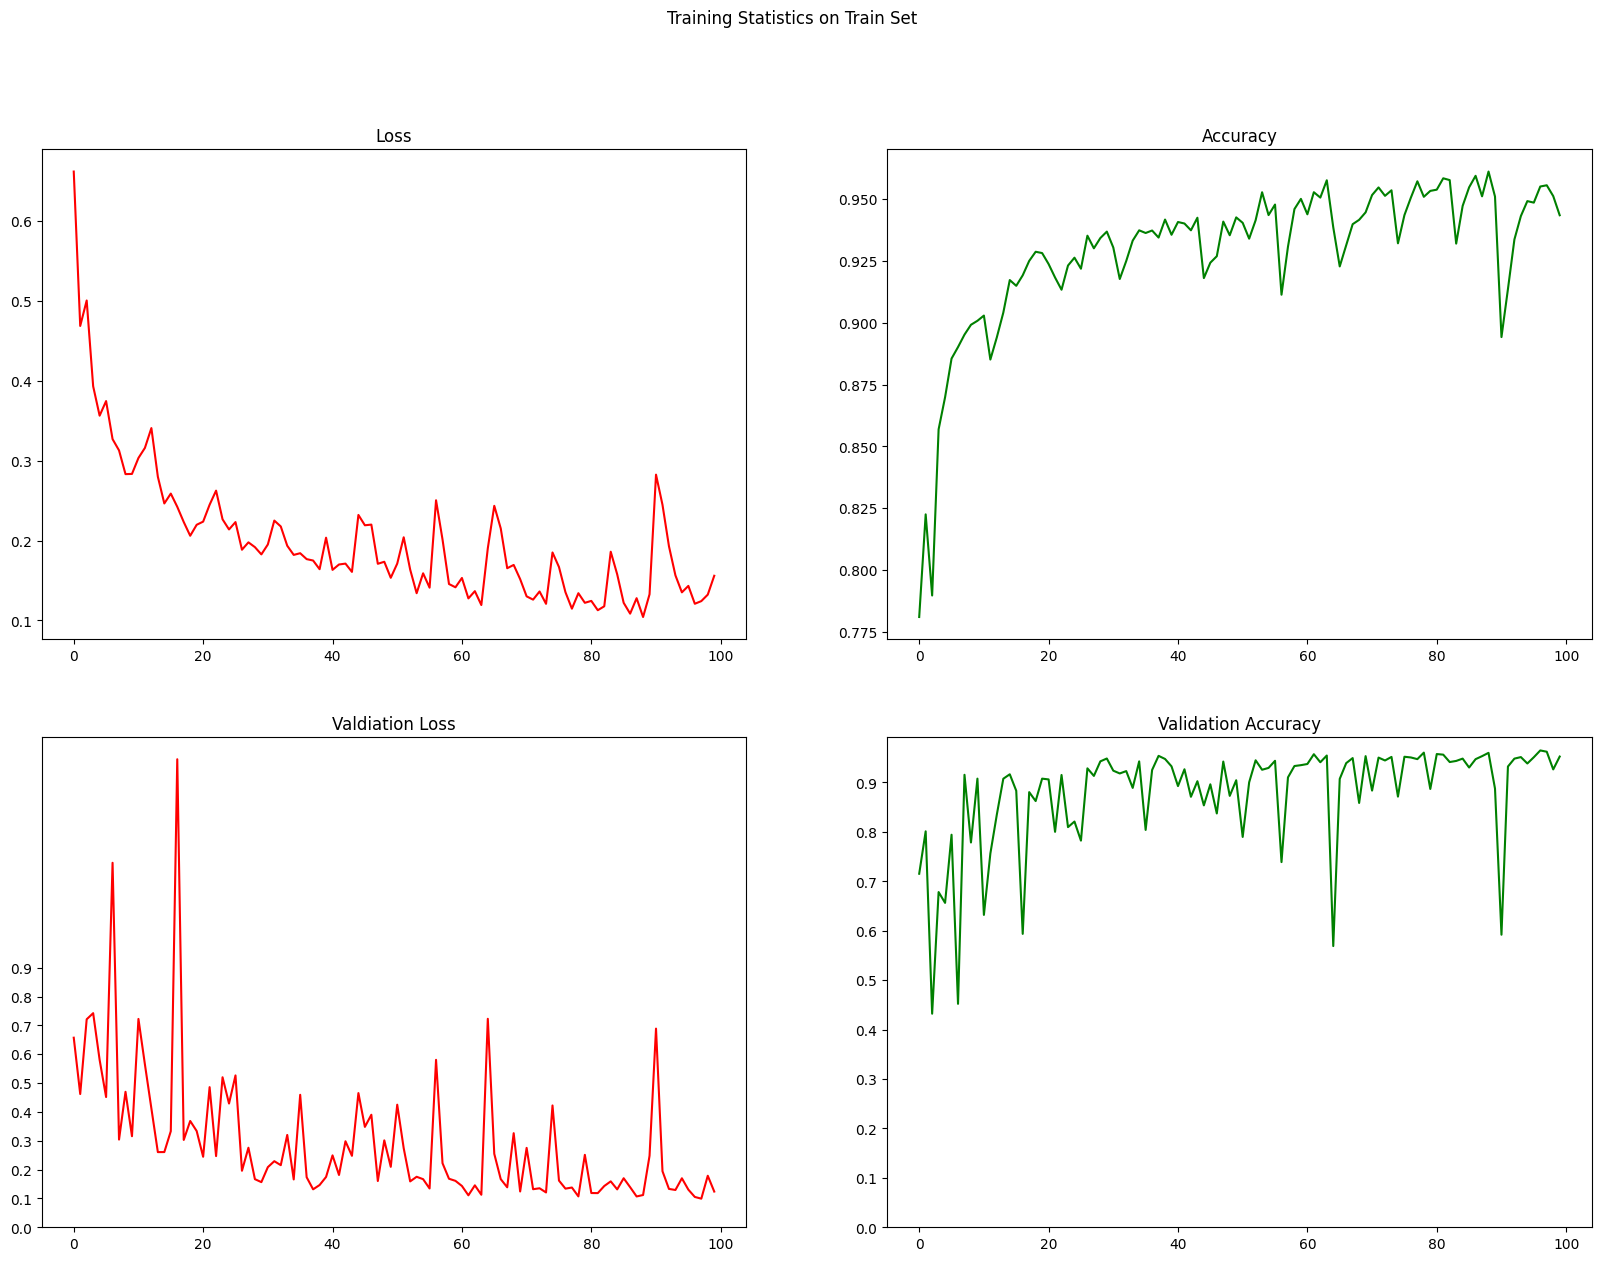

In [27]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

1/1 [==============================] - 5s 5s/step


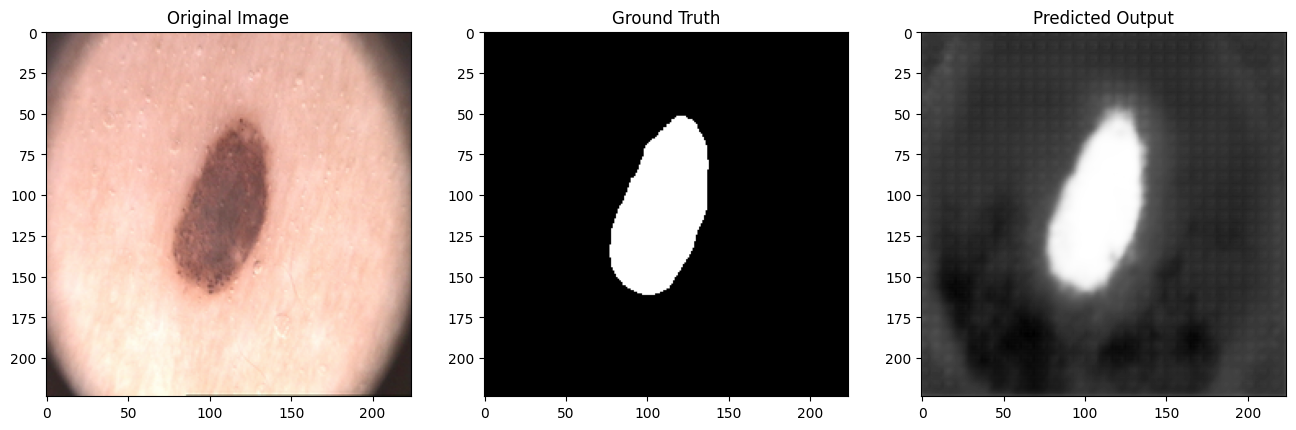

In [28]:
img_num = 30
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 1s 800ms/step


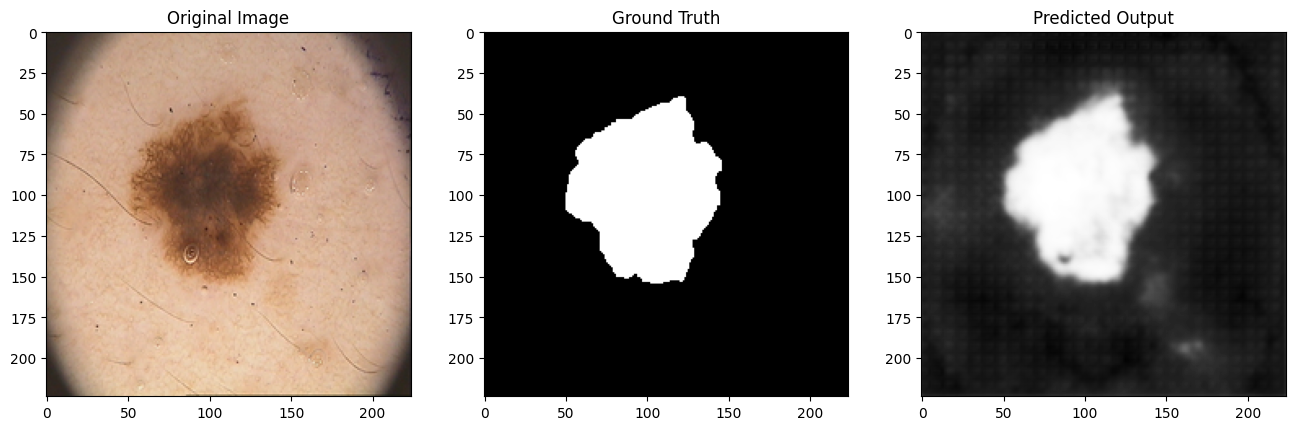

In [29]:
img_num = 10
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 52ms/step


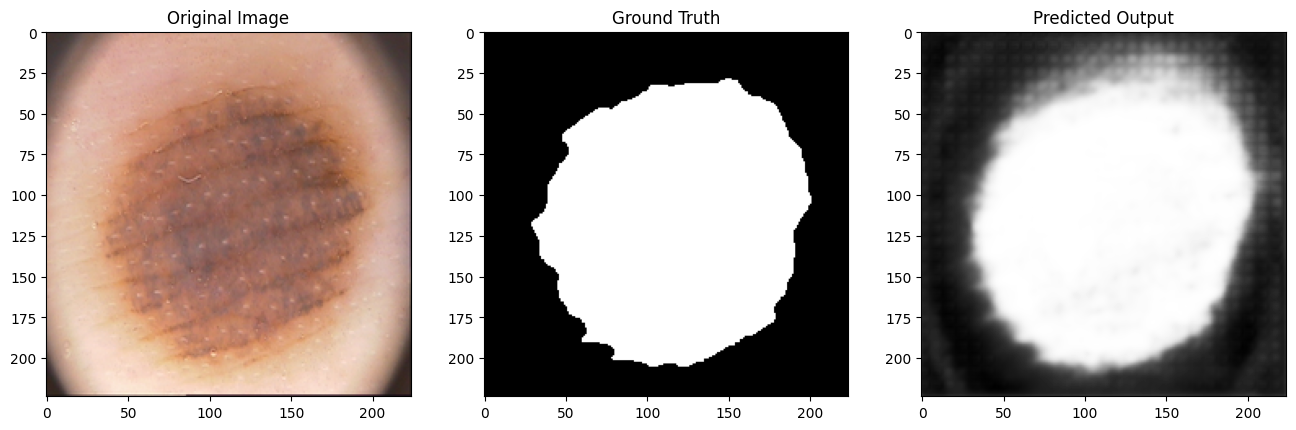

In [30]:
img_num = 36
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 224ms/step


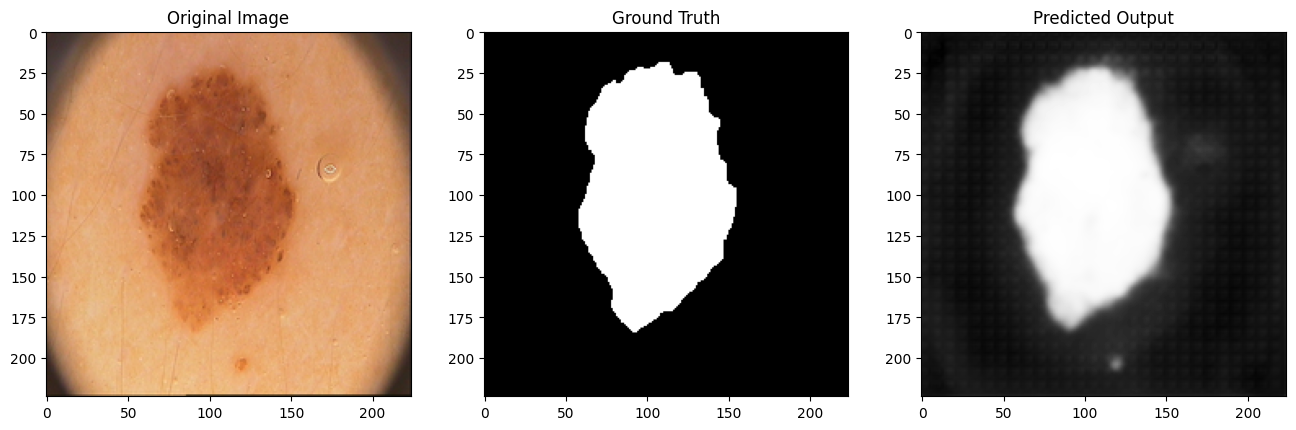

In [31]:
img_num = 32
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 55ms/step


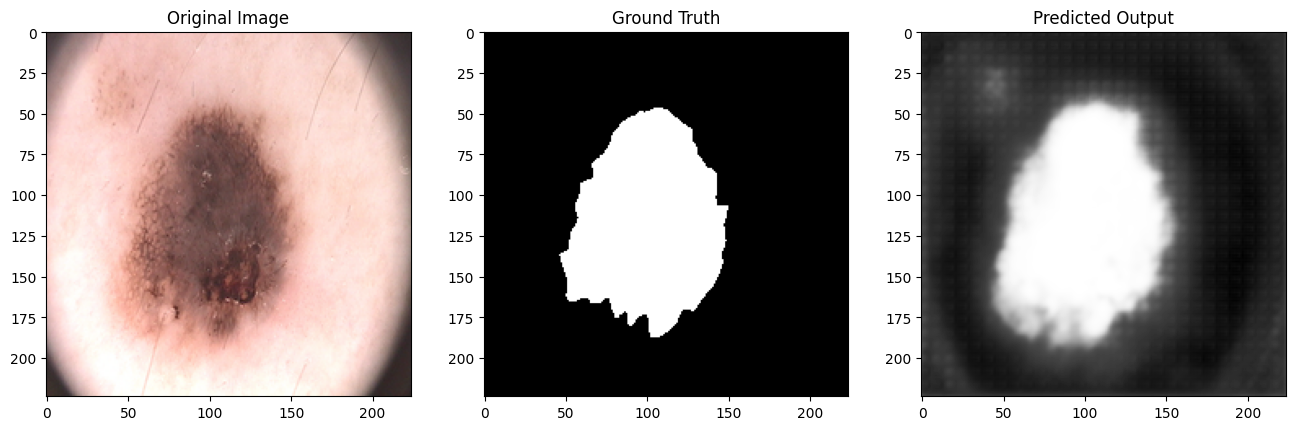

In [32]:
img_num = 29
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 1s 812ms/step


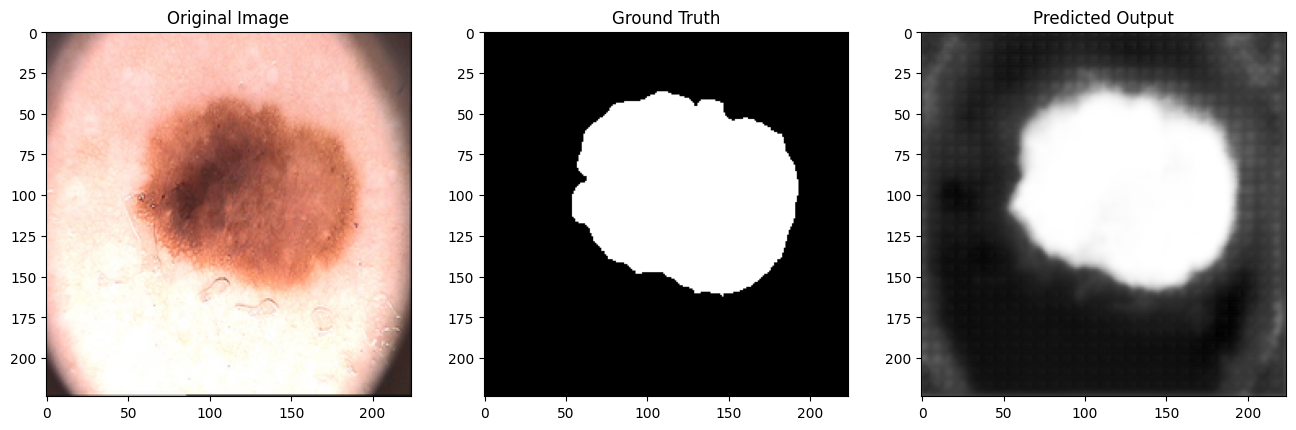

In [33]:
img_num = 21
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 42ms/step


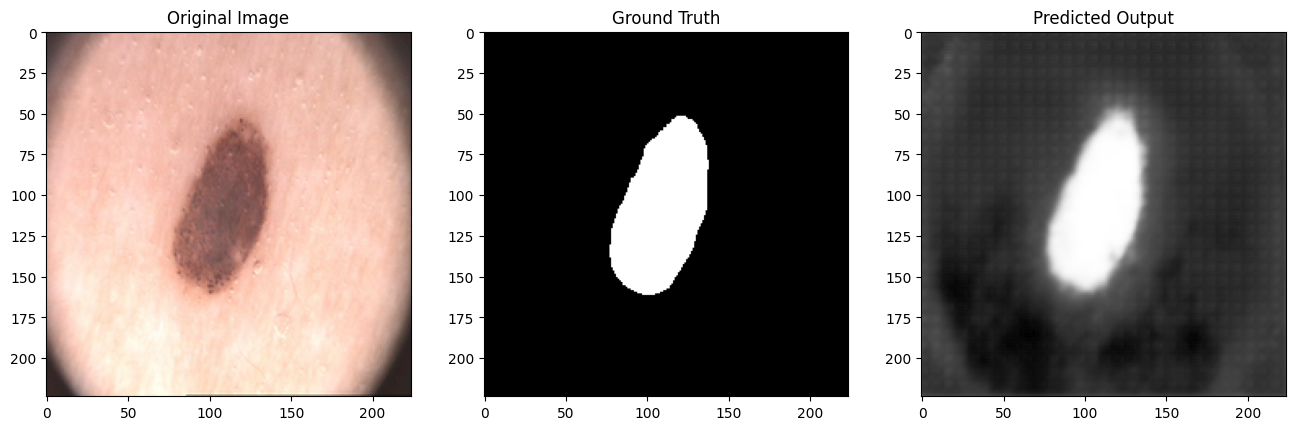

In [34]:
img_num = 30
img_pred = model.predict((x_test[img_num]).reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()



## Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.  
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5  .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values.

In [35]:
def enhance(img):
    sub = (model.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



1/1 [==============================] - 0s 65ms/step


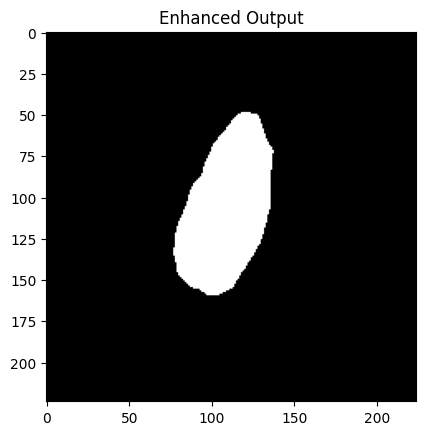

In [36]:
plt.imshow(enhance(x_test[img_num]).reshape(224,224), plt.cm.binary_r)
plt.title('Enhanced Output')
plt.show()

1/1 [==============================] - 4s 4s/step


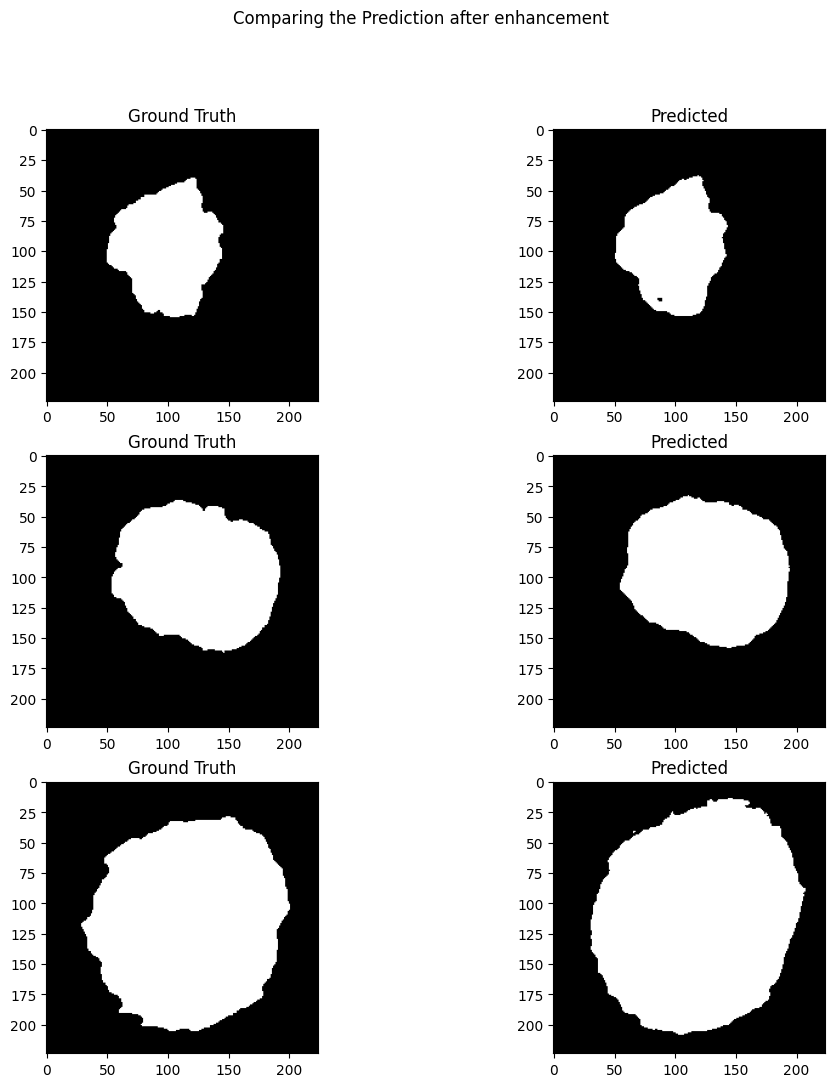

In [37]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[10],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[10]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

1/1 [==============================] - 0s 43ms/step


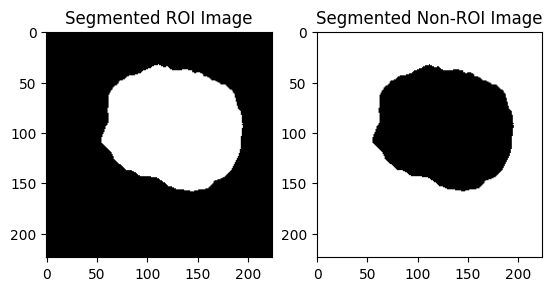

In [38]:
roi=enhance(x_test[21]).reshape(224,224)
nroi=1-roi

plt.subplot(1,2,1)
plt.imshow(roi,plt.cm.binary_r)
plt.title('Segmented ROI Image')
plt.subplot(1,2,2)
plt.imshow(nroi, plt.cm.binary_r)
plt.title('Segmented Non-ROI Image')
plt.show()


Text(0.5, 1.0, 'segmented Image')

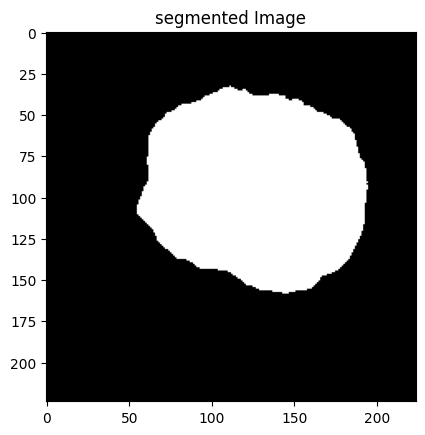

In [39]:
plt.imshow(cv2.merge((roi, roi, roi)) * x_test[21])
plt.title('segmented Image')

In [40]:
import cv2
import numpy as np
from sklearn.linear_model import LinearRegression

def predict_pixel_value(group_of_pixels):
    # Use linear regression for predicting pixel value
    X = np.arange(len(group_of_pixels)).reshape(-1, 1)
    y = group_of_pixels.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return int(model.predict([[len(group_of_pixels)]]))

def embed_watermark(image, watermark_bits, alpha=0.1):
    watermarked_image = np.zeros_like(image, dtype=np.float32)

    # Iterate over image pixels
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]

            # Predict the pixel value using linear regression
            group_of_pixels = image[max(0, i-1):min(image.shape[0], i+2), max(0, j-1):min(image.shape[1], j+2)].flatten()
            predicted_value = predict_pixel_value(group_of_pixels)

            # Modify the pixel value for embedding the watermark
            watermarked_image[i, j] = pixel_value + (watermark_bits[i, j] - 0.5) * 2 * alpha - predicted_value

    return watermarked_image

def extract_watermark(original_image, watermarked_image, alpha=0.1):
    extracted_watermark = np.zeros_like(original_image)

    # Iterate over image pixels
    for i in range(original_image.shape[0]):
        for j in range(original_image.shape[1]):
            original_pixel_value = original_image[i, j]
            watermarked_pixel_value = watermarked_image[i, j]

            # Predict the pixel value using linear regression
            group_of_pixels = original_image[max(0, i-1):min(original_image.shape[0], i+2),
                                             max(0, j-1):min(original_image.shape[1], j+2)].flatten()
            predicted_value = predict_pixel_value(group_of_pixels)

            # Extract the watermark
            extracted_watermark[i, j] = (watermarked_pixel_value - original_pixel_value + predicted_value) / (2 * alpha) + 0.5

    return extracted_watermark

# Example usage
original_image = roi
watermark_bits = np.random.randint(0, 2, size=original_image.shape)

# Embedding
watermarked_image = embed_watermark(original_image, watermark_bits)

# Extraction
extracted_watermark = extract_watermark(original_image, watermarked_image)

# Print the extracted watermark bits
print("Extracted Watermark Bits:")
print(np.round(extracted_watermark).astype(int))


Extracted Watermark Bits:
[[1 1 0 ... 1 0 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 1 1]]


In [41]:
print("Watermark Bits:",watermark_bits)


Watermark Bits: [[1 1 0 ... 1 0 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 1 1]]


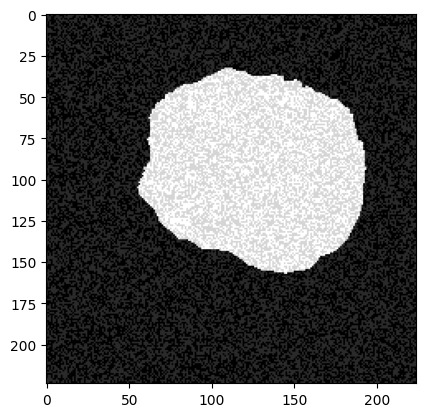

In [42]:
plt.imshow(roi-watermarked_image, plt.cm.binary_r)

**Metrics Evaluation**

In [43]:
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True)

def calculate_rce(img1, img2):
    std1 = np.std(img1)
    std2 = np.std(img2)

    # Avoid division by zero
    if std1 == 0 or std2 == 0:
        return 0

    rce = abs(std1 - std2) / max(std1, std2)
    return rce


psnr_value = calculate_psnr(roi, watermarked_image)
ssim_value = calculate_ssim(roi, watermarked_image)
# Calculate RCE-relative contrast error (RCE)
rce_value = calculate_rce(roi, watermarked_image)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")
print(f"RCE: {rce_value}")

PSNR: 53.852882932174964
SSIM: 0.08428163081407547
RCE: 0.6966736912727356
